In [1]:
import gensim.parsing.preprocessing as gsp
from gensim import utils
import json
import requests
from pprint import pprint
import gensim.corpora as corpora
from nltk.corpus import stopwords
import gensim
from gensim.utils import simple_preprocess
import nltk
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.wrappers import LdaMallet
import mysql.connector
import datetime
import time
from nltk.collocations import *
from nltk.tokenize import regexp
import json
from nltk import tokenize
import numpy as np
from tqdm import tqdm
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

# data preprocessing

In [2]:
# nltk.download('stopwords')
filters = [gsp.strip_tags, 
#            gsp.strip_punctuation, 
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric, 
           gsp.remove_stopwords, 
           gsp.strip_short]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

stop_words = ['sen', 'senator', 'senate', 'senators']

url_docs = requests.get("http://das-lab.org:1701/docs")
text_docs = url_docs.text
json_data_docs = json.loads(text_docs)

unprocessed_data = [o['doc_text'] for o in json_data_docs]
doc_ids = [o['doc_id'] for o in json_data_docs]
data = [clean_text(text) for text in unprocessed_data]

for i in range(len(data)):
    text_tokens = tokenize.word_tokenize(data[i])
    tokens = [word for word in text_tokens if not word in stop_words and len(word) > 1]
    data[i] = " ".join(tokens)

# lda preprocessing
tokenizer = regexp.RegexpTokenizer(r"\w+")
tokens = [tokenizer.tokenize(doc) for doc in data]

tokens = [tuple(doc) for doc in tokens]
id2word = corpora.Dictionary(tokens)
texts = tokens
corpus = [id2word.doc2bow(text) for text in texts]

# create lda mallet model

In [4]:
path_to_mallet_binary = "/Users/chasemattingly/mallet-2.0.6/bin/mallet"
model = LdaMallet(path_to_mallet_binary, corpus=corpus,
                  num_topics=25, id2word=id2word)

# compute coherence values vs num topics

In [74]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=5):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaMallet(path_to_mallet_binary, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_npmi')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [75]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, limit=50)

100%|██████████| 9/9 [09:41<00:00, 64.59s/it]


In [88]:
model = model_list[4]

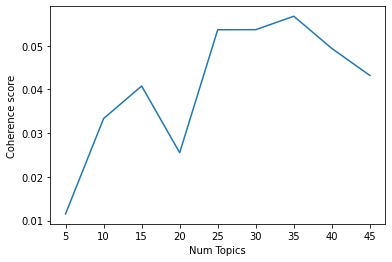

In [76]:
plt.plot(range(5,50, 5), coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

# post topics

In [33]:
json_dict_topics = dict(model.print_topics(num_topics=25))
json_dict_topics = {int(k):v for k,v in json_dict.items()}

In [35]:
req = requests.post("http://das-lab.org:1701/topics", json=json_dict_topics)

# get topic ids for doc_top_matrix

In [36]:
url_topics = requests.get("http://das-lab.org:1701/topics")
text_topics = url_topics.text
json_data_topics = json.loads(text_topics)

In [37]:
topic_ids = [o['topic_id'] for o in json_data_topics]

# compute doc_top_matrix

In [87]:
doc_top_matrix = [*model.load_document_topics()]

# add zero probability for topics not included

In [92]:
expected_keys = list(range(25))
new_doc_top_matrix = []
for doc_top in doc_top_matrix:
    _dict = dict(doc_top)
    for key in expected_keys:
        if key not in _dict:
            _dict[key] = 0
    new_doc_top_matrix.append(list(_dict.items()))
        

# obtain excerpts

In [9]:
excerpts = []
for i in tqdm(range(len(unprocessed_data))):
    excerpts_topic = [None] * 25
    sents = tokenize.sent_tokenize(unprocessed_data[i])
#     max_topic = max(doc_top_matrix[i], key=lambda x:x[1])[0]
    for topic, prob in doc_top_matrix[i]:
        words_prob = dict(model.show_topic(topic, topn=None)) #topn=None to obtain all word probabilities
        sums = []
        for sent in sents:
            words = tokenize.word_tokenize(sent)
            probs = [words_prob[word] if word in words_prob else 0 for word in words]
            sums.append(sum(probs))
        excerpts_topic[topic] = sents[np.argmax(sums)]
    excerpts.append(excerpts_topic)

100%|██████████| 2582/2582 [24:35<00:00,  1.75it/s]


# create JSON payload

In [96]:
json_dict = {}

In [97]:
it = 0
for i in range(len(new_doc_top_matrix)):
    doc_top = sorted(new_doc_top_matrix[i])
    for j in range(len(new_doc_top_matrix[i])):
        json_dict[it] = {"doc_id": doc_ids[i], "topic_id": topic_ids[doc_top[j][0]], "probability": round(doc_top[j][1], 4), "excerpt": excerpts[i][j]}
        it += 1

In [9]:
with open("doc_top.json", "w") as outfile:
    json.dump(json_dict, outfile)

In [98]:
req = requests.post("http://das-lab.org:1701/doctopics", json=json_dict)

In [99]:
req

<Response [200]>